# Evaluation

This notebook contains the code for the evaluation of the simulated response times generated under the true and random form-to-meaning mappings. This notebook follows the structure of the thesis in presenting the code for these analysis:
- Comparison of simulated response time distributions
  - Overall distributional properties
  - Local distributional properties
  - The role of word frequency<br><br>

- Comparison simulated response times and human response times
  - Lexical decision (BLP data)
    - Correlations
    - Predictor effects
  - Semantic decision (CSDP data)
    - Correlations
    - Predictor effects

## Preliminaries

Load the libraries required for running the simulations.

In [1]:
# Load libraries
library(psych)
suppressMessages(library(car))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
library(tidyr)
suppressMessages(library(mgcv))
library(cocor)

Read in the data from the British Lexicon Project and the Calgary Semantic Decision Project.

In [2]:
# Read in BLP data for the true and random mapping
blp = readRDS("data/blp_simulation.rds")
blp_random = readRDS("data/blp_simulation_random.rds")

# Read in CSDP data for the true and random mapping
csdp = readRDS("data/csdp_simulation.rds")
csdp_random = readRDS("data/csdp_simulation_random.rds")

Define predictor and predictor labels for plots

In [3]:
# Define predictors and predictor labels
predictors = c("LogFrequency", "LogMeanBigramFrequency", "Length", "LogOLD20Norm")
predictor_labels = c("frequency", "bigram frequency", "length", "OLD20")
names(predictor_labels) = predictors
predictor_axis_labels = c("(log) frequency", "(log) mean bigram freq.", "length", 
  "(log) OLD20")
names(predictor_axis_labels) = predictors

Define plotting function for the results of the generalized additive models (GAMs)

In [4]:
# Define plotting function
plot.fnc = function(model, data, predictor, axis_labels, n_points = 100, 
  ylab = "RT", ylim = NA) {
  
  # Generate model predictions
  model_predictors = names(model$var.summary)
  predictor_values = list()
  for(model_predictor in model_predictors) {
    if(model_predictor == predictor) {
      predictor_values[[model_predictor]] = seq(min(data[,predictor]), 
        max(data[,predictor]),length.out = n_points)
    } else {
      predictor_values[[model_predictor]] = median(data[,model_predictor])
    }
  }
  predictions = as.data.frame(predictor_values)
  predicted_values = predict(model, newdata = predictions, type = "response", 
    se.fit = TRUE)
  predictions$fit = predicted_values$fit
  predictions$lower = predicted_values$fit - 1.96 * predicted_values$se.fit
  predictions$upper = predicted_values$fit + 1.96 * predicted_values$se.fit
  
  # Plot
  plot(predictions[,predictor], predictions$fit, type = "n", 
    xlab = axis_labels[predictor], ylab = ylab, ylim = ylim, main = "", 
    cex.lab = 1.1)
  polygon(c(predictions[,predictor], rev(predictions[,predictor])),
          c(predictions$upper, rev(predictions$lower)),
          col = "#EEEEEE", border = NA)
  lines(predictions[,predictor], predictions$fit, lwd = 1.3)
  
}

## Comparison of simulated response time distributions

We compare the distributions of the simulated response times under the true and the random form-to-meaning mappings through three analyses: an analysis of overall distributional properties, an analysis of local distributional properties, and an analysis of the role of word frequency.

### Overall distributional properties

We run tests comparing the overall shape of the distributions of both sets of simulated response times. Furthermore, we generate descriptive statistics as well as a density plot of both distributions.

#### Descriptive statistics

Get the descriptive statistics of the response time distribution under the true and random form-meaning mappings.

In [5]:
# True mapping
describe(blp$SimRT)

# Random mapping
describe(blp_random$SimRT)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,14558,5.218925,1.841673,5.437779,5.328255,1.906146,-9.99995e-06,11.51293,11.51294,-0.4953458,-0.2474118,0.01526376


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,14558,5.626734,1.983034,5.972971,5.789168,1.963951,-9.99995e-06,11.51293,11.51294,-0.6768367,-0.07792141,0.01643537


#### Test comparing overall shape of distributions

We conduct a Kolmogorov-Smirnov test to find out if the distributions of the simulated response times under the true and random mapping are identical.

In [6]:
# Run Kolmogorov-Smirnov test
suppressWarnings(ks.test(blp$SimRT, blp_random$SimRT))


	Asymptotic two-sample Kolmogorov-Smirnov test

data:  blp$SimRT and blp_random$SimRT
D = 0.11664, p-value < 2.2e-16
alternative hypothesis: two-sided


#### Test comparing means of distributions

We conduct a test to find out if the means of the simulated response times under the true and random mapping are the same

In [7]:
# Make a data frame that combines simulated response times for both mappings
blp_combined = data.frame("SimRT" = c(blp$SimRT, blp_random$SimRT),
                          "Mapping" = c(rep("true", nrow(blp)),
                                        rep("random", nrow(blp_random))))
blp_combined$Mapping = factor(blp_combined$Mapping, levels = c("true", "random"))

# Run a Levene's test for equal variances
# leveneTest(SimRT ~ Mapping, data = blp_combined)[1,]
# (Variances are not equal, we therefore need a Welch two-sample t-test)

# Run Welch two-sample t-test
t.test(blp$SimRT, blp_random$SimRT, var.equal = FALSE)


	Welch Two Sample t-test

data:  blp$SimRT and blp_random$SimRT
t = -18.181, df = 28956, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4517720 -0.3638445
sample estimates:
mean of x mean of y 
 5.218925  5.626734 


#### Density plot

We generate a plot of the probability density function for the simulated response times under both distributions.

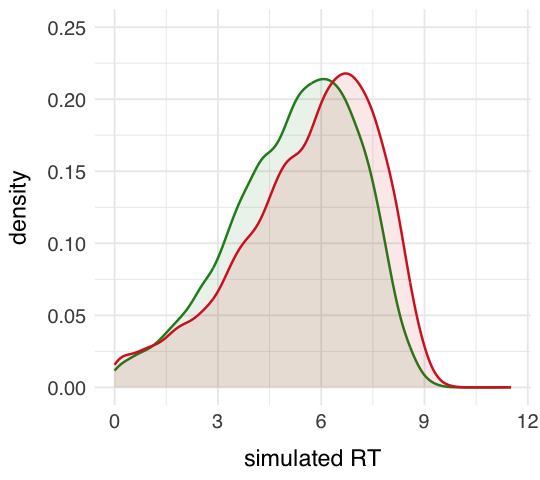

In [8]:
# Set plot parameters 
options(repr.plot.width = 4.5, repr.plot.height = 4)

# Make density plot
ggplot(blp_combined, aes(x = SimRT, fill = Mapping, color = Mapping)) +
  geom_density(alpha = 0.1, linewidth = 0.7) +
  theme_minimal(base_family = "sans") +
  labs(x = "simulated RT", y = "density") +
  scale_fill_manual(values = c("true" = "#228B22", "random" = "#D62728")) +
  scale_color_manual(values = c("true" = "#228B22", "random" = "#D62728")) +
  coord_cartesian(ylim = c(0, 0.25)) +
  theme(
    legend.position = "none",
    text = element_text(size = 14, family = "sans"),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
  )

### Local distributional properties

We compare the log odds of random versus true words across bins of the simulated response time distributions. Furthermore, we compare the counts of response times generated under the true and random form-to-meaning mappings in the tails of the distributions through a $\chi^2$ test.

#### Log odds random versus true words

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


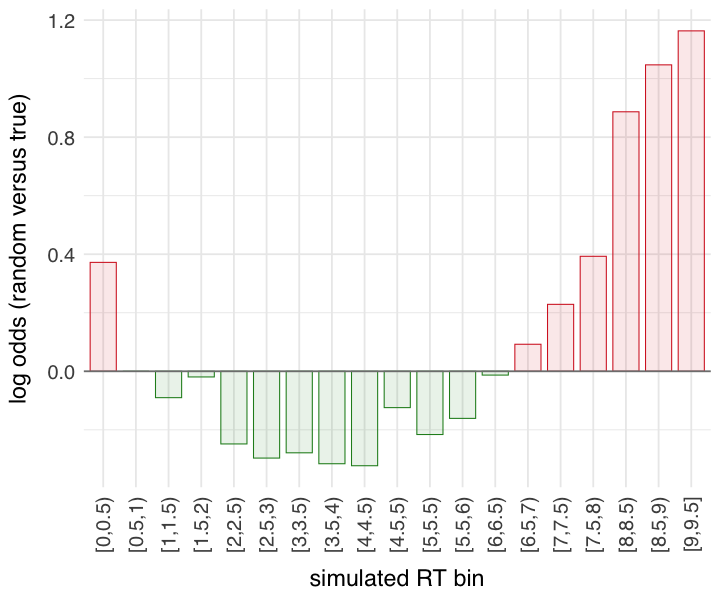

In [9]:
# Bin simulated response times
blp_combined$Bin = cut(blp_combined$SimRT, breaks = seq(0, 9.5, by = 0.5),
                       include.lowest = TRUE, right = FALSE)
blp_combined = blp_combined[!is.na(blp_combined$Bin), ]

# Count words per bin for each mapping
bin_counts = blp_combined %>%
  group_by(Bin, Mapping) %>%
  summarise(Count = n(), .groups = "drop") %>%
  pivot_wider(names_from = Mapping, values_from = Count, values_fill = 0)

# Compute logodds
bin_counts = bin_counts %>%
  mutate(Logodds  = log(random/true), FillColor  = 
    ifelse(Logodds > 0, "#D62728", "#228B22"))

# Set plot parameters 
options(repr.plot.width = 6, repr.plot.height = 5)

# Plot
ggplot(bin_counts, aes(x = Bin, y = Logodds, fill = FillColor, 
  color = FillColor)) +
  geom_col(fill = NA, color = NA) + 
  geom_col(alpha = 0.1, size = 0.3, width = 0.80) + 
  scale_fill_identity() +
  scale_color_identity() +
  geom_hline(yintercept = 0, color = "#7F7F7F", linetype = "solid") +
  labs(x = "simulated RT bin", y = "log odds (random versus true)") +
  theme_minimal(base_family = "sans") +
  theme(
    text = element_text(size = 14),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.y = element_text(size = 12),
    axis.text.x = element_text(angle = 90, vjust = 0.5, size = 12)
  )

#### Analysis of the tails

First, an analysis of extreme left tail of the distribution.

In [10]:
# Define threshold for inclusion in the extreme left tail
# (1st percentile of simulated response times under the true mapping)
round(quantile(blp$SimRT, 0.01), 2)

# Get number of words in the extreme left tail under both mappings
table(blp$SimRT < 0.48)
table(blp_random$SimRT < 0.48)

# Conduct a Chi-square test
tab = table(blp_combined$SimRT < 0.48, blp_combined$Mapping)
chisq.test(tab)

1% 
0.48


FALSE  TRUE 
14413   145 


FALSE  TRUE 
14359   199 


	Pearson's Chi-squared test with Yates' continuity correction

data:  tab
X-squared = 10.073, df = 1, p-value = 0.001504


In [11]:
# Define threshold for inclusion in the extreme left tail
# (1st percentile of simulated response times under the true mapping)
round(quantile(blp$SimRT, 0.99), 2)

# Get number of words in the extreme left tail under both mappings
table(blp$SimRT < 8.51)
table(blp_random$SimRT < 8.51)

# Conduct a Chi-square test
tab = table(blp_combined$SimRT < 8.50, blp_combined$Mapping)
chisq.test(tab)

99% 
8.51


FALSE  TRUE 
  144 14414 


FALSE  TRUE 
  419 14139 


	Pearson's Chi-squared test with Yates' continuity correction

data:  tab
X-squared = 136.63, df = 1, p-value < 2.2e-16


### The role of word frequency

We conduct an analysis of the effect of word frequency on the difference between simulated response times generated under the true and random mapping using a generalized additive model (GAM).


Family: gaussian 
Link function: identity 

Formula:
DiffRT ~ s(LogFrequency, k = 4)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.40781    0.01303    31.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df     F p-value    
s(LogFrequency) 2.838  2.978 177.1  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.035   Deviance explained = 3.51%
GCV = 2.4719  Scale est. = 2.4713    n = 14558

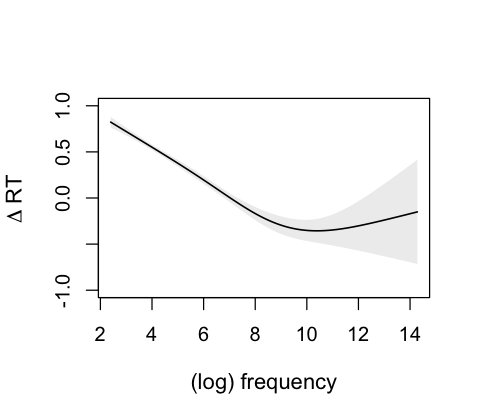

In [12]:
# Define column with response time difference
blp$DiffRT = blp_random$SimRT - blp$SimRT

# Run GAM
gam_diff = gam(DiffRT ~ s(LogFrequency, k = 4), data = blp)

# Show model summary
summary(gam_diff)

# Set plot parameters 
options(repr.plot.width = 4, repr.plot.height = 3.5)

# Plot frequency effect
plot.fnc(gam_diff, blp, "LogFrequency", axis_labels = predictor_axis_labels, 
  ylim = c(-1, 1), ylab = expression(Delta~RT))

## Comparison simulated response times and human response times

We compare the degree to which simulated response times under the true and the random form-to-meaning mappings align with human response times in two tasks: the lexical decision task and the semantic decision task. For each task, we look at the correlation between simulated and observed response times and at the effects of well-known predictors from the psycholinguistic literature.

### Lexical decision data

We conduct analyses on the lexical decision data from the British Lexicon Project (BLP).

#### Correlations

We determine and compare the correlation between observed reponse times and response times generated under the true and random mapping.

In [13]:
# Get correlations
r12 = cor(blp$RTInv, blp$SimRT)
r13 = cor(blp_random$RTInv, blp_random$SimRT)
r23 = cor(blp$SimRT, blp_random$SimRT)

# Run statistical test
cocor.dep.groups.overlap(r.jk = r12, r.jh = r13, r.kh = r23, n = length(blp$RTInv))


  Results of a comparison of two overlapping correlations based on dependent groups

Comparison between r.jk = 0.4795 and r.jh = 0.5537
Difference: r.jk - r.jh = -0.0741
Related correlation: r.kh = 0.6521
Group size: n = 14558
Null hypothesis: r.jk is equal to r.jh
Alternative hypothesis: r.jk is not equal to r.jh (two-sided)
Alpha: 0.05

pearson1898: Pearson and Filon's z (1898)
  z = -12.9188, p-value = 0.0000
  Null hypothesis rejected

hotelling1940: Hotelling's t (1940)
  t = -13.1103, df = 14555, p-value = 0.0000
  Null hypothesis rejected

williams1959: Williams' t (1959)
  t = -13.0156, df = 14555, p-value = 0.0000
  Null hypothesis rejected

olkin1967: Olkin's z (1967)
  z = -12.9188, p-value = 0.0000
  Null hypothesis rejected

dunn1969: Dunn and Clark's z (1969)
  z = -12.9750, p-value = 0.0000
  Null hypothesis rejected

hendrickson1970: Hendrickson, Stanley, and Hills' (1970) modification of Williams' t (1959)
  t = -13.1103, df = 14555, p-value = 0.0000
  Null hypothesis

#### Predictor effects

We fit a generalized additive model (GAM) with word frequency, word length, mean bigram frequency, and orthographic neighborhood density (OLD20) to the observed response times, the simulated response times under the true mapping, and the simulated response times under the random mapping.

In [14]:
# Fit models
gam_observed = gam(RTInv ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), data = blp, 
  method = "REML")
gam_true = gam(SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), data = blp,
  method = "REML")
gam_random = gam(SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), data = blp_random, 
  method = "REML")

# Re-fit models, excluding residual outliers
gam_observed = gam(RTInv ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), 
  data = blp[abs(scale(resid(gam_observed)))<=3,], method = "REML")
gam_true = gam(SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), 
  data = blp[abs(scale(resid(gam_true)))<=3,], method = "REML")
gam_random = gam(SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), 
  data = blp_random[abs(scale(resid(gam_random)))<=3,], method = "REML")

# Show model summaries
summary(gam_observed)
summary(gam_true)
summary(gam_random)


Family: gaussian 
Link function: identity 

Formula:
RTInv ~ s(LogFrequency, k = 4) + s(Length, k = 4) + s(LogOLD20Norm, 
    k = 4) + s(LogMeanBigramFrequency, k = 4)

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.6706592  0.0009295   -1797   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df        F p-value    
s(LogFrequency)           2.977  3.000 2879.074  <2e-16 ***
s(Length)                 1.003  1.005  246.479  <2e-16 ***
s(LogOLD20Norm)           2.947  2.998   42.884  <2e-16 ***
s(LogMeanBigramFrequency) 1.068  1.132    2.502  0.0966 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.446   Deviance explained = 44.6%
-REML = -11148  Scale est. = 0.012544  n = 14520


Family: gaussian 
Link function: identity 

Formula:
SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + s(LogOLD20Norm, 
    k = 4) + s(LogMeanBigramFrequency, k = 4)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.28059    0.00715   738.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df       F p-value    
s(LogFrequency)           2.949  2.998 14172.6  <2e-16 ***
s(Length)                 2.965  2.999   652.1  <2e-16 ***
s(LogOLD20Norm)           2.956  2.999   868.3  <2e-16 ***
s(LogMeanBigramFrequency) 2.913  2.995   499.3  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.772   Deviance explained = 77.2%
-REML =  18079  Scale est. = 0.73094   n = 14296


Family: gaussian 
Link function: identity 

Formula:
SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + s(LogOLD20Norm, 
    k = 4) + s(LogMeanBigramFrequency, k = 4)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.690147   0.005515    1032   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df       F p-value    
s(LogFrequency)           2.991  3.000 33261.0  <2e-16 ***
s(Length)                 2.976  2.999   904.4  <2e-16 ***
s(LogOLD20Norm)           2.935  2.997   826.4  <2e-16 ***
s(LogMeanBigramFrequency) 2.814  2.976   276.3  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.883   Deviance explained = 88.3%
-REML =  14393  Scale est. = 0.43537   n = 14312

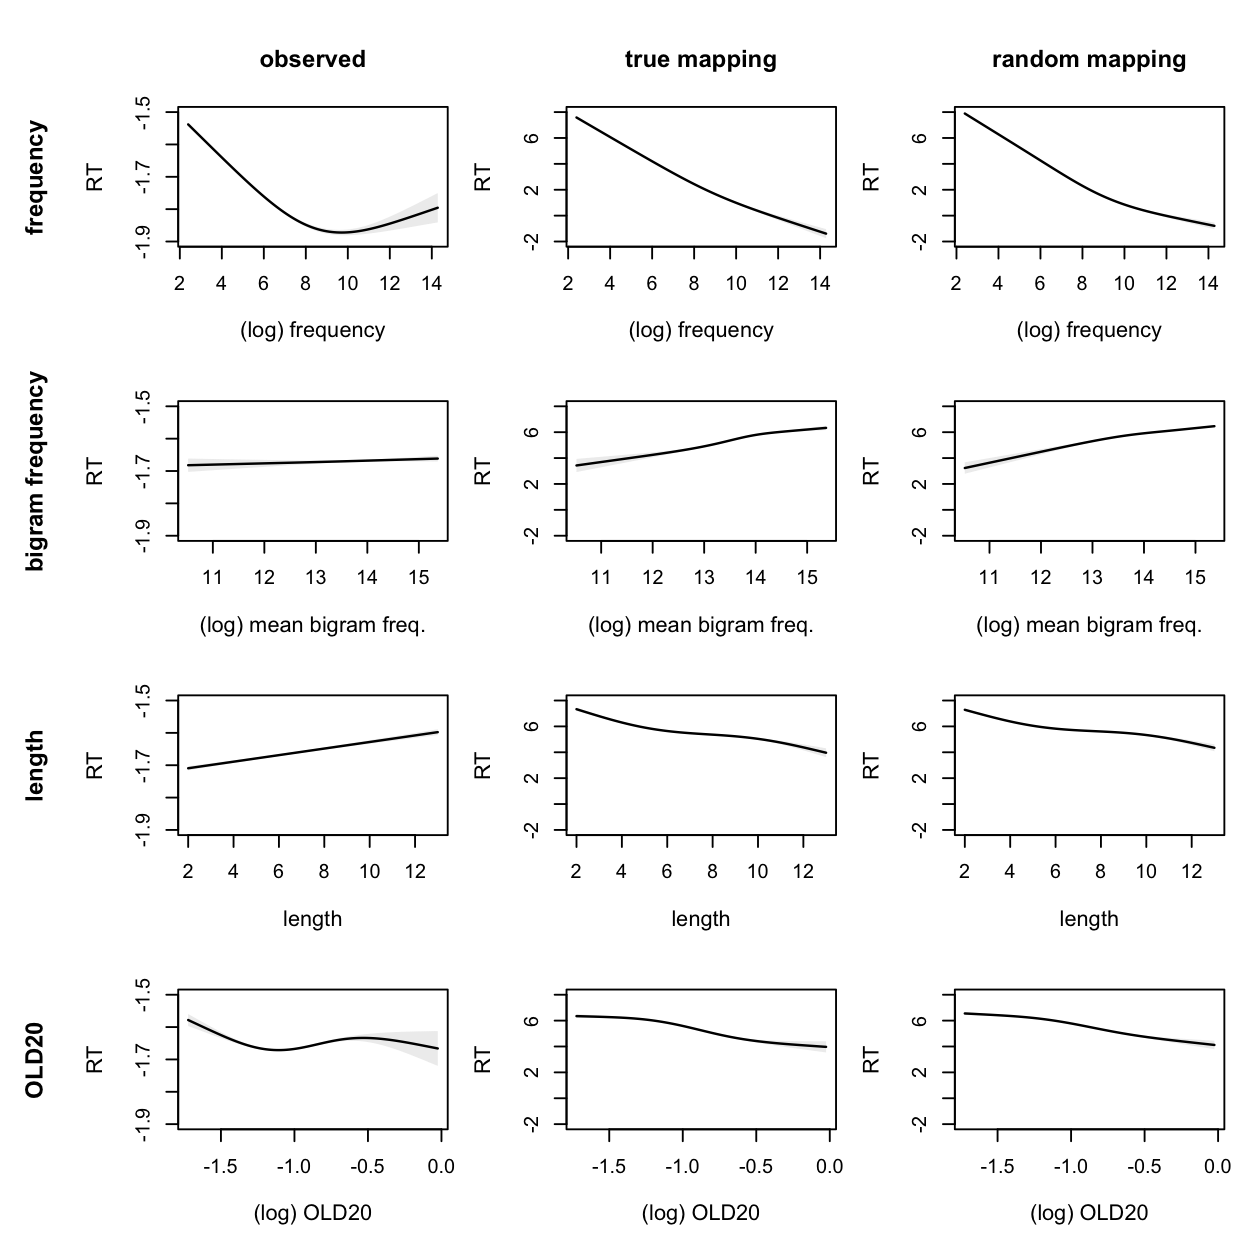

In [15]:
# Set plot parameters
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 180)
par(mfrow = c(4, 3), mar = c(4.5, 4, 2, 1), oma = c(1, 3.5, 2.5, 0.5))

# Plot
for(predictor in predictors) {
  
  # Plot observed effect
  plot.fnc(gam_observed, blp, predictor, predictor_axis_labels, ylab = "RT", 
    ylim = c(-1.9,-1.5))
  mtext(predictor_labels[predictor], side = 2, line = 5.5, outer = FALSE, 
    font = 2, cex = 0.8)
  if(predictor == predictors[1]) {
    mtext("observed", side = 3, line = 1.5, outer = FALSE, font = 2, cex = 0.8)
  }
  # Plot simulated effect under true mapping
  plot.fnc(gam_true, blp, predictor, predictor_axis_labels, ylab = "RT", 
    ylim = c(-2,8))
  if(predictor == predictors[1]) {
    mtext("true mapping", side = 3, line = 1.5, outer = FALSE, font = 2, 
      cex = 0.8)
  }
  # Plot simulated effect under random mapping
  plot.fnc(gam_random, blp, predictor, predictor_axis_labels, ylab = "RT", 
    ylim = c(-2,8))
  if(predictor == predictors[1]) {
    mtext("random mapping", side = 3, line = 1.5, outer = FALSE, font = 2,
      cex = 0.8)
  }
  
}

### Semantic decision data

We conduct analyses on the semantic decision data from the Calgary Semantic Decision Project (CSDP).

#### Correlations

We determine and compare the correlation between observed reponse times and response times generated under the true and random mapping.

In [16]:
# Get correlations
r12 = cor(csdp$LogRT, csdp$SimRT)
r13 = cor(csdp_random$LogRT, csdp_random$SimRT)
r23 = cor(csdp$SimRT, csdp_random$SimRT)

# Run statistical test
cocor.dep.groups.overlap(r.jk = r12, r.jh = r13, r.kh = r23, n = length(csdp$LogRT))


  Results of a comparison of two overlapping correlations based on dependent groups

Comparison between r.jk = 0.2423 and r.jh = 0.2097
Difference: r.jk - r.jh = 0.0326
Related correlation: r.kh = 0.5784
Group size: n = 3406
Null hypothesis: r.jk is equal to r.jh
Alternative hypothesis: r.jk is not equal to r.jh (two-sided)
Alpha: 0.05

pearson1898: Pearson and Filon's z (1898)
  z = 2.1377, p-value = 0.0325
  Null hypothesis rejected

hotelling1940: Hotelling's t (1940)
  t = 2.1408, df = 3403, p-value = 0.0324
  Null hypothesis rejected

williams1959: Williams' t (1959)
  t = 2.1375, df = 3403, p-value = 0.0326
  Null hypothesis rejected

olkin1967: Olkin's z (1967)
  z = 2.1377, p-value = 0.0325
  Null hypothesis rejected

dunn1969: Dunn and Clark's z (1969)
  z = 2.1366, p-value = 0.0326
  Null hypothesis rejected

hendrickson1970: Hendrickson, Stanley, and Hills' (1970) modification of Williams' t (1959)
  t = 2.1408, df = 3403, p-value = 0.0324
  Null hypothesis rejected

steige

#### Predictor effects

We fit a generalized additive model (GAM) with word frequency, word length, mean bigram frequency, and orthographic neighborhood density (OLD20) to the observed response times, the simulated response times under the true mapping, and the simulated response times under the random mapping.

In [17]:
# Fit models
gam_observed = gam(LogRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), data = csdp, 
  method = "REML")
gam_true = gam(SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), data = csdp,
  method = "REML")
gam_random = gam(SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), data = csdp, 
  method = "REML")

# Re-fit models, excluding residual outliers
gam_observed = gam(LogRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), 
  data = csdp[abs(scale(resid(gam_observed)))<=3,], method = "REML")
gam_true = gam(SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), 
  data = csdp[abs(scale(resid(gam_true)))<=3,], method = "REML")
gam_random = gam(SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + 
  s(LogOLD20Norm, k = 4) + s(LogMeanBigramFrequency, k = 4), 
  data = csdp_random[abs(scale(resid(gam_random)))<=3,], method = "REML")

# Show model summaries
summary(gam_observed)
summary(gam_true)
summary(gam_random)


Family: gaussian 
Link function: identity 

Formula:
LogRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + s(LogOLD20Norm, 
    k = 4) + s(LogMeanBigramFrequency, k = 4)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.872989   0.002175    3161   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df       F p-value    
s(LogFrequency)           1.617  1.958 125.106 < 2e-16 ***
s(Length)                 1.004  1.009   6.833 0.00896 ** 
s(LogOLD20Norm)           1.001  1.002 115.011 < 2e-16 ***
s(LogMeanBigramFrequency) 1.004  1.007   9.698 0.00183 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0915   Deviance explained = 9.28%
-REML =  -2173  Scale est. = 0.016074  n = 3399


Family: gaussian 
Link function: identity 

Formula:
SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + s(LogOLD20Norm, 
    k = 4) + s(LogMeanBigramFrequency, k = 4)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.11692    0.01786   286.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df       F p-value    
s(LogFrequency)           2.120  2.488 2394.64  <2e-16 ***
s(Length)                 2.480  2.803   98.35  <2e-16 ***
s(LogOLD20Norm)           2.392  2.755  198.31  <2e-16 ***
s(LogMeanBigramFrequency) 1.002  1.004  204.27  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.654   Deviance explained = 65.5%
-REML = 4892.5  Scale est. = 1.07      n = 3356


Family: gaussian 
Link function: identity 

Formula:
SimRT ~ s(LogFrequency, k = 4) + s(Length, k = 4) + s(LogOLD20Norm, 
    k = 4) + s(LogMeanBigramFrequency, k = 4)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.73825    0.01398   410.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df       F p-value    
s(LogFrequency)           2.663  2.912 4443.16  <2e-16 ***
s(Length)                 2.888  2.990  167.16  <2e-16 ***
s(LogOLD20Norm)           2.843  2.981  167.33  <2e-16 ***
s(LogMeanBigramFrequency) 1.989  2.419   62.28  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.812   Deviance explained = 81.2%
-REML = 4076.3  Scale est. = 0.65547   n = 3356

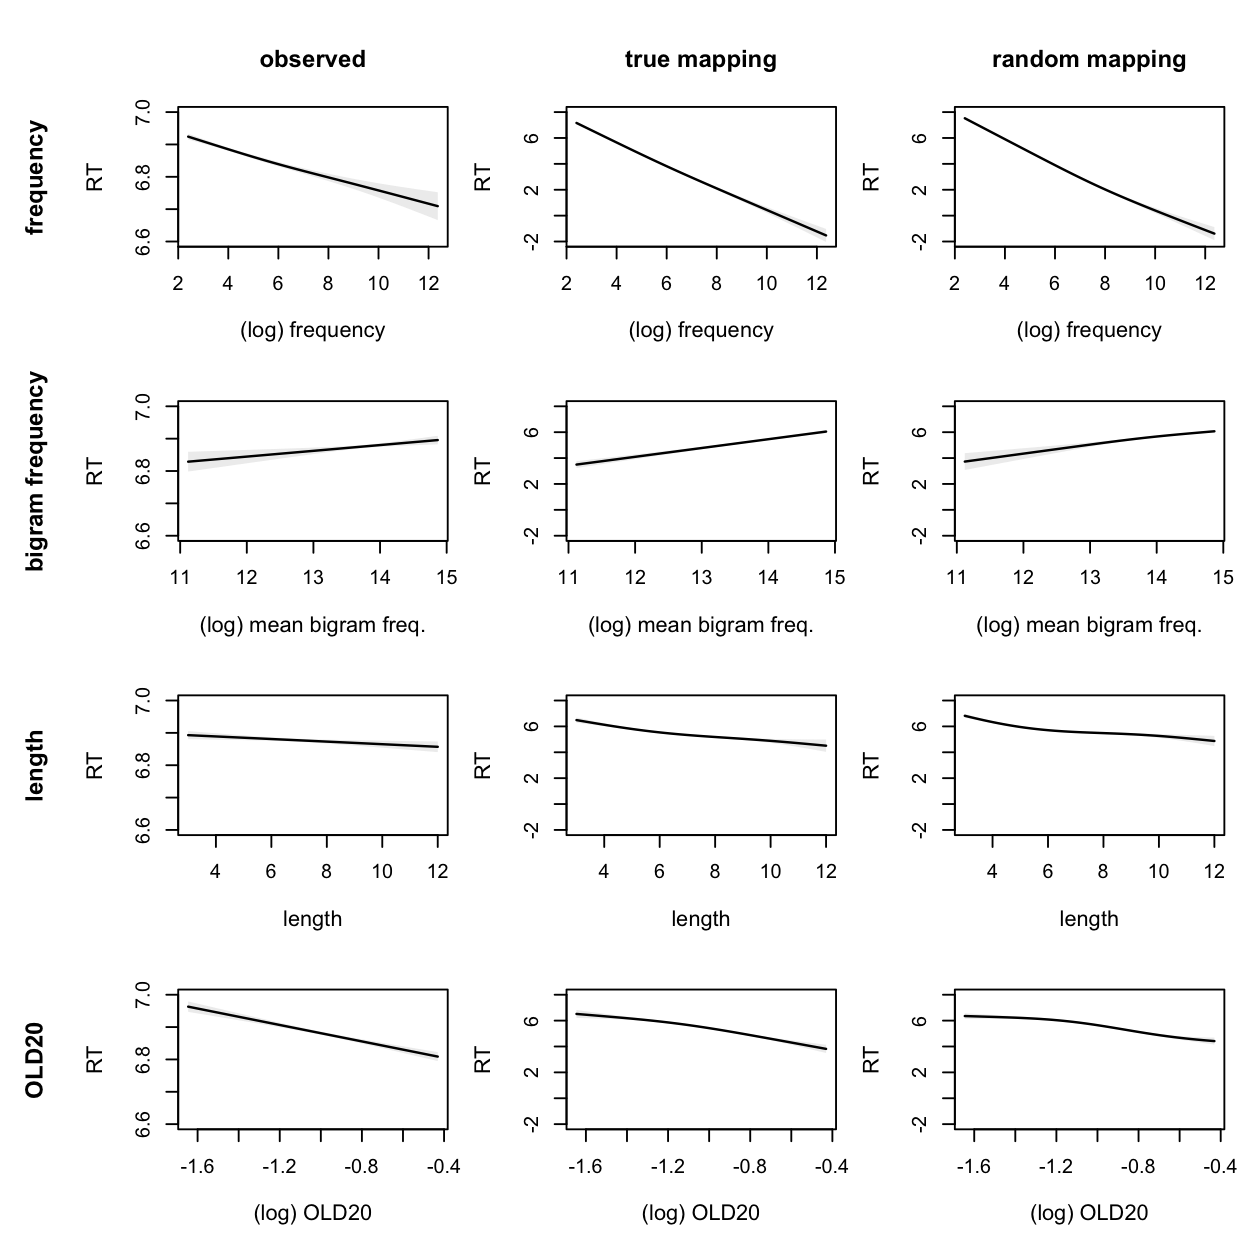

In [18]:
# Set plot parameters
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 180)
par(mfrow = c(4, 3), mar = c(4.5, 4, 2, 1), oma = c(1, 3.5, 2.5, 0.5))

# Plot
for(predictor in predictors) {
  
  # Plot observed effect
  plot.fnc(gam_observed, csdp, predictor, predictor_axis_labels, ylab = "RT", 
    ylim = c(6.6,7))
  mtext(predictor_labels[predictor], side = 2, line = 5.5, outer = FALSE, 
    font = 2, cex = 0.8)
  if(predictor == predictors[1]) {
    mtext("observed", side = 3, line = 1.5, outer = FALSE, font = 2, cex = 0.8)
  }
  # Plot simulated effect under true mapping
  plot.fnc(gam_true, csdp, predictor, predictor_axis_labels, ylab = "RT", 
    ylim = c(-2,8))
  if(predictor == predictors[1]) {
    mtext("true mapping", side = 3, line = 1.5, outer = FALSE, font = 2, 
      cex = 0.8)
  }
  # Plot simulated effect under random mapping
  plot.fnc(gam_random, csdp, predictor, predictor_axis_labels, ylab = "RT", 
    ylim = c(-2,8))
  if(predictor == predictors[1]) {
    mtext("random mapping", side = 3, line = 1.5, outer = FALSE, font = 2,
      cex = 0.8)
  }
  
}